# Notes

This notebook is an example of a PRE-PROCESSING and SEGMENTATION pipeline for satellite images.
It is not meant to be run as a script, but rather to be used as a reference for how to use the preprocessing and segmentation functions.

**IMPORTANT** This notebook assumes one has stored a series of *unpacked* RAS and RHD files in the VISTA format containing 
- The RGB (red,green,blue) reflectance values as a tensor of images over time (bands B2, B3, B4).
- The NIR (near-infrared) reflectance values as a tensor of images over time (band B8A).
- Information of the datetimes and the coordinates of the images. 

The VISTA format is not publicly available, but the functions in this notebook can be used as a reference for how to preprocess satellite images in general.

*Example scenario*: We have downloaded the RAS and RHD files containing the RGBNIR and SCL values for a sentinel-2 tile (~12k by 12k image) over the span of 2020. We want to preprocess this data for segmentation of fields.

*Author*: Jens d'Hondt (TU Eindhoven)

In [1]:
# General imports
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
from stelar_spatiotemporal.eolearn.core import EOPatch, OverwritePermission, FeatureType, SaveTask, LoadTask
import geopandas as gpd

/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set minio credentials
os.environ["MINIO_ENDPOINT_URL"] = "http://localhost:9000"
os.environ["MINIO_ACCESS_KEY"] = "minioadmin"
os.environ["MINIO_SECRET_KEY"] = "minioadmin"

S3DATADIR = "s3://stelar-spatiotemporal/RGB"
LOCAL_DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/data/pipeline_example"
TMPDIR = "/tmp"

segment_dates = [dt.datetime(2020, 7, 7)]

# 0 Unpacking the data

This step unpacks a RAS-RHD file pair with reflection band values into a series of .npy files, named by the date of the image and aggregated by the band name.
(e.g. `B2/2020_1_1.npy`, `B2/2020_1_2.npy`, ...) 
The unpacking can be done using the `unpack_vista_unzipped` function in `stelar_spatiotemporal/preprocessing/vista_preprocessing.py`, as shown below.

**Assumptions**:
- One has downloaded and unzipped the RAS and RHD files for all necessary bands [B2,B3,B4,B8A] to be processed. And stored them in folders grouped by the respective band name. E.g.,:
```
B2/
    2020_1_1.RAS
    2020_1_1.RHD
    2020_1_2.RAS
    2020_1_2.RHD
    ...
B3/
    2020_1_1.RAS
    2020_1_1.RHD
    2020_1_2.RAS
    2020_1_2.RHD
    ...
B4/
    2020_1_1.RAS
    2020_1_1.RHD
    2020_1_2.RAS
    2020_1_2.RHD
    ...
B8A/
    2020_1_1.RAS
    2020_1_1.RHD
    2020_1_2.RAS
    2020_1_2.RHD
    ...
```
- The RAS files can contain multiple images, each with a different date, month or year.

**Process**:
The function `unpack_vista_unzipped` will do the following:
1. Extract the images from the RAS file and store them in a series of .npy files named by the date of the individual image, based on the accompanied RHD file.

In [7]:
from sentinelhub import CRS
from stelar_spatiotemporal.preprocessing.vista_preprocessing import BandsDataPackage, unpack_vista_reflectance

b2_path = os.path.join(S3DATADIR, "B2")
b3_path = os.path.join(S3DATADIR, "B2")
b4_path = os.path.join(S3DATADIR, "B2")
b8_path = os.path.join(S3DATADIR, "B2")

bands_data_package = BandsDataPackage(b2_path, b3_path, b4_path, b8_path, file_extension="RAS")

# Unpacks RAS and RHD files into numpy arrays
# unpack_vista_reflectance(bands_data_package, outdir=TMPDIR, crs=CRS(32630))

# 1. Combining bands for segmentation data

In this step we will combine the different bands into a tensor, or package of images. 
As we will only perform segmentation over a small selection of images (particularly, certain dates with good weather and representative field separation), we advice to pass this selection into the function `combine_bands` as a list of dates.
Otherwise, the function will combine all images in the specified folder into a tensor, which can be very large and unnecessary if one then only uses a subset of those images for segmentation.

**Assumptions**:
- One has stored the .npy files containing the images of each band in a folder `$DATADIR` following the structure `DATADIR/{B2,B3,B4,B8A}/{date}.npy`.

**Process**:
The function `combine_bands` will do the following:
1. Create a tensor of images for the RGBNIR bands (B2, B3, B4, B8A).
2. Combine the tensor of images, the mask, the corresponding datetimes and bounding box into a single EOPatch object and save in folder `DATADIR/segment_eopatch`.

In [8]:
from stelar_spatiotemporal.segmentation.segmentation import combine_rgb_npys_into_eopatch

# Create band data package with local paths
b2_path = os.path.join(TMPDIR, "B2")
b3_path = os.path.join(TMPDIR, "B3")
b4_path = os.path.join(TMPDIR, "B4")
b8_path = os.path.join(TMPDIR, "B8A")

npy_data_package = BandsDataPackage(b2_path, b3_path, b4_path, b8_path, file_extension="npy")

eop_path = combine_rgb_npys_into_eopatch(npy_data_package, outdir=TMPDIR , dates = segment_dates)

print(eop_path)

Combining segment dates into one eopatch per band
Processing 1 partitions of 1 dates each
Processing 1 partitions of 1 dates each
Processing 1 partitions of 1 dates each
Processing 1 partitions of 1 dates each
Combining eopatches into one eopatch
Saving eopatch
/tmp/segment_eopatch


# 2. Splitting segmentation data to patchlets

Next, we will split the EOPatch containing the data for the full tile (12k by 12k pixels) into smaller patchlets (1128 by 1128 pixels) with slight overlap between them. This is done to make the data more manageable for the next steps in the pipeline, particularly segmentation, for which the model works best with smaller images.

**Assumptions**:
- One has stored the EOPatch object containing the data for the full tile in a folder `$DATADIR/segment_eopatch`.

In [9]:
from stelar_spatiotemporal.segmentation.segmentation import patchify_segmentation_data

plet_dir = os.path.join(TMPDIR, "patchlets")

patchify_segmentation_data(eop_path, outdir=plet_dir, n_jobs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:14<00:00, 14.83s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


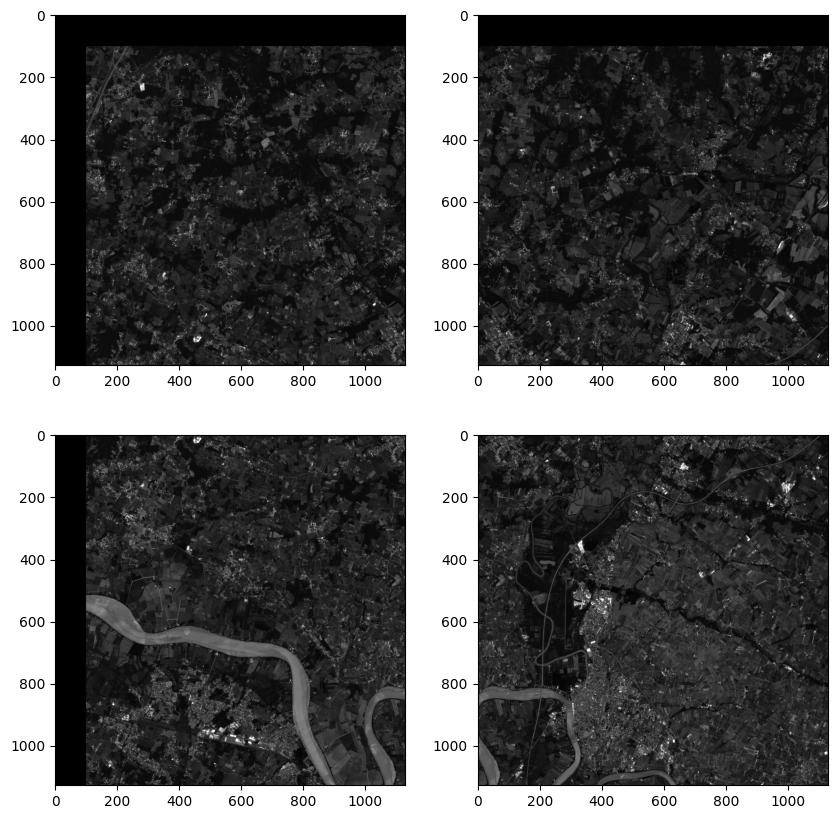

In [10]:
from stelar_spatiotemporal.eopatch_functions import plot_rgb
from stelar_spatiotemporal.eolearn.core import EOPatch

# Check patchlets results (with overlap)
indir = plet_dir
eop1 = EOPatch.load(indir + "/patchlet_0_0", lazy_loading=True)
eop2 = EOPatch.load(indir + "/patchlet_1_0", lazy_loading=True)
eop3 = EOPatch.load(indir + "/patchlet_0_1", lazy_loading=True)
eop4 = EOPatch.load(indir + "/patchlet_1_1", lazy_loading=True)

fig,axes = plt.subplots(2,2,figsize=(10,10))

plot_rgb(eop1, 0, axes[0,0])
plot_rgb(eop2, 0, axes[0,1])
plot_rgb(eop3, 0, axes[1,0])
plot_rgb(eop4, 0, axes[1,1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

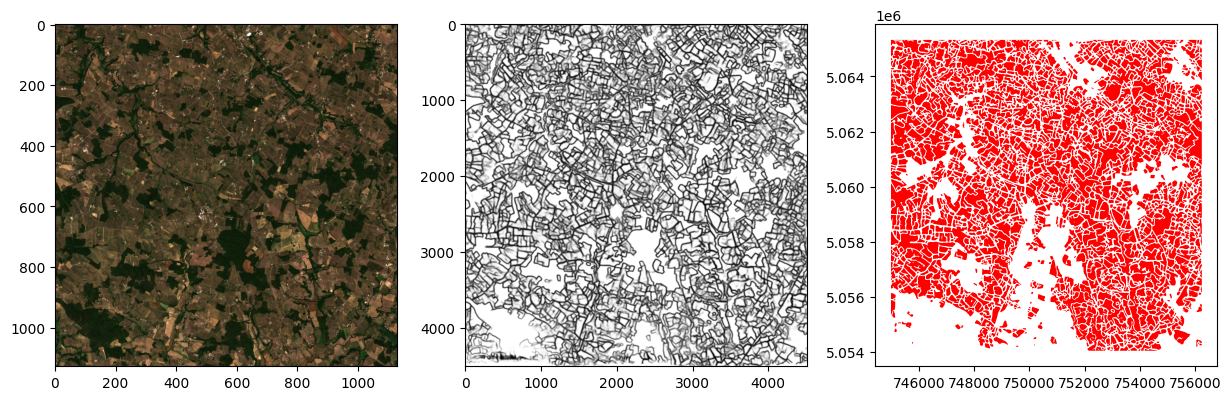

In [35]:
eop = EOPatch.load(indir + "/patchlet_4_3", lazy_loading=True)

fig,axes = plt.subplots(1,3, figsize=(15,5))

# Plot RGB image
rgb_data = eop.data['BANDS'][0]
axes[0].imshow(rgb_data[..., [2,1,0]] / 10000 * 3.5)

# Plot segmentation mask
seg_data = eop.data_timeless['SEGMENTATION']
axes[1].imshow(seg_data, vmin=0, vmax=1, cmap='gray')

# Plot fields
field_path = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_workbench/data/pipeline_example/contours/patchlet_4_3.gpkg"

fields = gpd.read_file(field_path)

# Fiter fields on area
minarea = 1000 # 1 km2
maxarea = 500_000 # 50 hectares

fields = fields[(fields.geometry.area > minarea) & (fields.geometry.area < maxarea)]
fields.plot(ax=axes[2], color='red')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


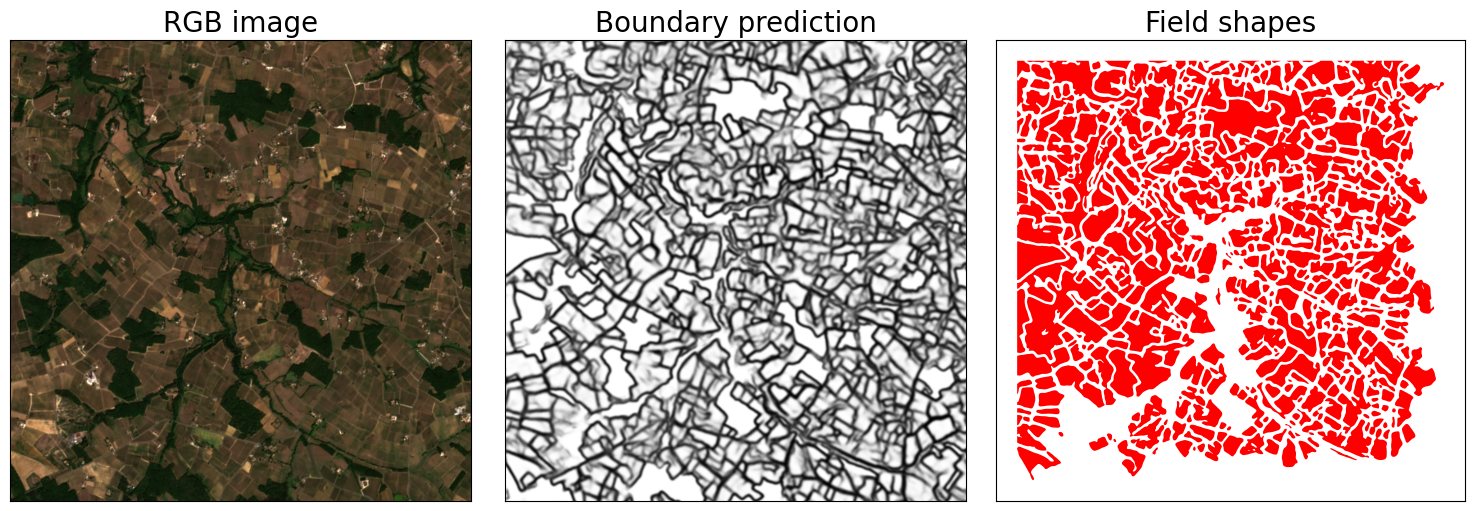

In [55]:
# Now filter to first quadrant
fig, axes = plt.subplots(1,3, figsize=(15,5))

title_fontsize = 20

# Plot RGB image
w,h = rgb_data.shape[:2]
axes[0].imshow(rgb_data[:int(w/2),:int(h/2), [2,1,0]] / 10000 * 3.5)
axes[0].set_title("RGB image", fontsize=title_fontsize)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot segmentation mask
w,h = seg_data.shape[:2]
axes[1].imshow(seg_data[:int(w/2),:int(h/2)], vmin=0, vmax=1, cmap='gray')
axes[1].set_title("Boundary prediction", fontsize=title_fontsize)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Plot fields
xmin, ymin, xmax, ymax = fields.total_bounds
w = (xmax - xmin) * .45
h = (ymax - ymin) * .45
fields_view = fields.cx[xmin:xmin+w, ymax-h:ymax]

fields_view.plot(ax=axes[2], color='red')
axes[2].set_title("Field shapes", fontsize=title_fontsize)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show()

In [41]:
w,h

(378127.5, 2532662.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


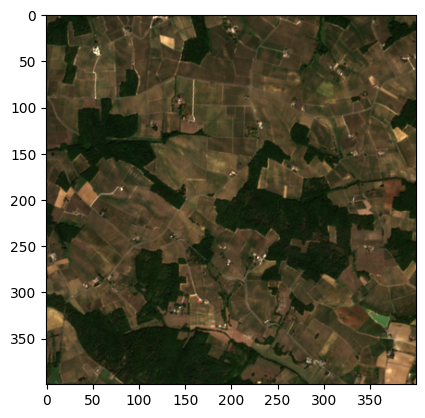

In [10]:
data = eop.data['BANDS'][0]

data = data[600:1000, :400, :]

plt.imshow(data[..., [2,1,0]] / 10000 * 3.5)

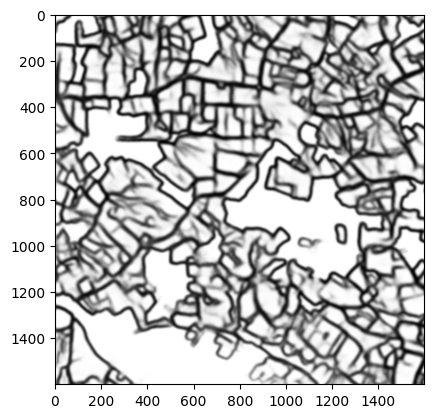

In [18]:
data = eop.data_timeless['SEGMENTATION']

xmin, xmax = 600, 1000
ymin, ymax = 0, 400

xmin *= 4
xmax *= 4
ymin *= 4
ymax *= 4

data = data[xmin:xmax, ymin:ymax, 0]

plt.imshow(data, vmin=0, vmax=1, cmap='gray')

In [25]:
# Map the ranges of pixels to coordinates in the original image using eop.bbox

bbox = eop.bbox

view_xmin, view_xmax = 600, 1000
view_ymin, view_ymax = 0, 400

w_px_ratio = (bbox.max_x - bbox.min_x) / 1128
h_px_ratio = (bbox.max_y - bbox.min_y) / 1128

xmin = bbox.min_x + view_xmin * w_px_ratio
xmax = bbox.min_x + view_xmax * w_px_ratio
ymin = bbox.min_y + view_ymin * h_px_ratio
ymax = bbox.min_y + view_ymax * h_px_ratio

xmin, xmax, ymin, ymax

(750975.0, 754975.0, 5054045.0, 5058045.0)

<Axes: >

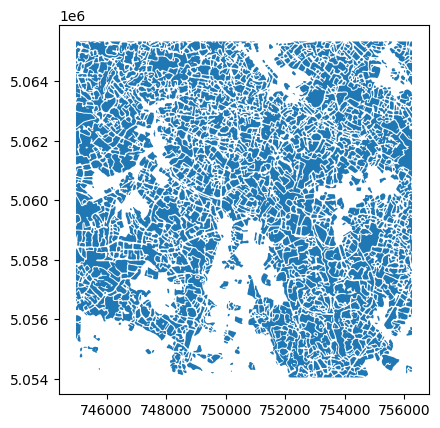

In [32]:
# Get fields

field_path = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_workbench/data/pipeline_example/contours/patchlet_4_3.gpkg"

fields = gpd.read_file(field_path)

# Fiter fields on area
minarea = 1000 # 1 km2
maxarea = 500_000 # 50 hectares

fields = fields[(fields.geometry.area > minarea) & (fields.geometry.area < maxarea)]

# Filter fields on location
# field_view = fields.cx[xmin:xmax, ymin:ymax]

fields.plot()

# field_view

# 3. Segmentation

In this step we will perform segmentation on the patchlets. We will use a pre-trained U-Net model with a ResNet34 backbone. The model will run inference on each of the images (i.e., dates) in the patchlets and combine those predictions to form a segmentation map for the patchlet. The segmentation map will be stored in the EOPatch object under the feature name `SEGMENTATION`.

**Assumptions**:
- One has stored the EOPatch objects containing the patchlets in a folder `$DATADIR/patchlets/segment_eopatch`.
- One has stored the pre-trained model in a folder `$MODELDIR`.

**Process**:
The function `segment_patchlets` will do the following:
1. Load the pre-trained model.
2. Run inference on each of the images in the patchlets.
3. Combine the predictions into a segmentation map for the patchlet.
4. Save the segmentation map in the EOPatch object under the feature name `SEGMENTATION`.

In [11]:
from stelar_spatiotemporal.segmentation.segmentation import segment_patchlets, load_model

MODELDIR = "s3://stelar-spatiotemporal/resunet-a_avg_2023-03-25-21-24-38"
# MODELDIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/model/resunet-a_avg_2023-03-25-21-24-38"

segment_patchlets(MODELDIR, plet_dir)

Loading model
1/121: Segmenting /tmp/patchlets/patchlet_1_9


2023-10-11 16:51:01.821145: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 254803968 exceeds 10% of free system memory.
2023-10-11 16:51:03.312910: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.
2023-10-11 16:51:03.313113: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.
2023-10-11 16:51:03.560667: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 509607936 exceeds 10% of free system memory.
2023-10-11 16:51:05.699797: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.


1/1 [==============================] - 14s 14s/step


/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/stelar_spatiotemporal/segmentation/segmentation.py:78: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  boundary = smooth(boundary, disk_size=disk_size)
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/stelar_spatiotemporal/segmentation/segmentation.py:80: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  array = smooth(boundary, disk_size=disk_size * scale_factor)


2/121: Segmenting /tmp/patchlets/patchlet_0_4
1/1 [==============================] - 12s 12s/step
3/121: Segmenting /tmp/patchlets/patchlet_4_3
1/1 [==============================] - 12s 12s/step
4/121: Segmenting /tmp/patchlets/patchlet_7_0
1/1 [==============================] - 13s 13s/step
5/121: Segmenting /tmp/patchlets/patchlet_10_9


/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/stelar_spatiotemporal/segmentation/segmentation.py:104: RuntimeWarning: invalid value encountered in divide
  norm_bands = (bands - mean_stats) / std_stats


1/1 [==============================] - 12s 12s/step


/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/stelar_spatiotemporal/lib.py:103: RuntimeWarning: All-NaN slice encountered
  return np.nan_to_num(np.nanmedian(array, axis=0))
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/stelar_spatiotemporal/lib.py:125: RuntimeWarning: invalid value encountered in divide
  rescaled = (rescaled - np.min(rescaled)) / (np.max(rescaled) - np.min(rescaled))
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/.venv/lib/python3.9/site-packages/skimage/util/dtype.py:317: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/src/STELAR_spatiotemporal/stelar_spatiotemporal/lib.py:111: RuntimeWarning: invalid value encountered in divide
  smoothed = (smoothed - 

6/121: Segmenting /tmp/patchlets/patchlet_6_2
1/1 [==============================] - 12s 12s/step
7/121: Segmenting /tmp/patchlets/patchlet_1_4
1/1 [==============================] - 11s 11s/step
8/121: Segmenting /tmp/patchlets/patchlet_0_2
1/1 [==============================] - 11s 11s/step
9/121: Segmenting /tmp/patchlets/patchlet_0_5
1/1 [==============================] - 11s 11s/step
10/121: Segmenting /tmp/patchlets/patchlet_7_9
1/1 [==============================] - 11s 11s/step
11/121: Segmenting /tmp/patchlets/patchlet_10_4
1/1 [==============================] - 11s 11s/step
12/121: Segmenting /tmp/patchlets/patchlet_3_6
1/1 [==============================] - 13s 13s/step
13/121: Segmenting /tmp/patchlets/patchlet_4_7
1/1 [==============================] - 11s 11s/step
14/121: Segmenting /tmp/patchlets/patchlet_1_10
1/1 [==============================] - 11s 11s/step
15/121: Segmenting /tmp/patchlets/patchlet_2_5
1/1 [==============================] - 11s 11s/step
16/121: Segm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


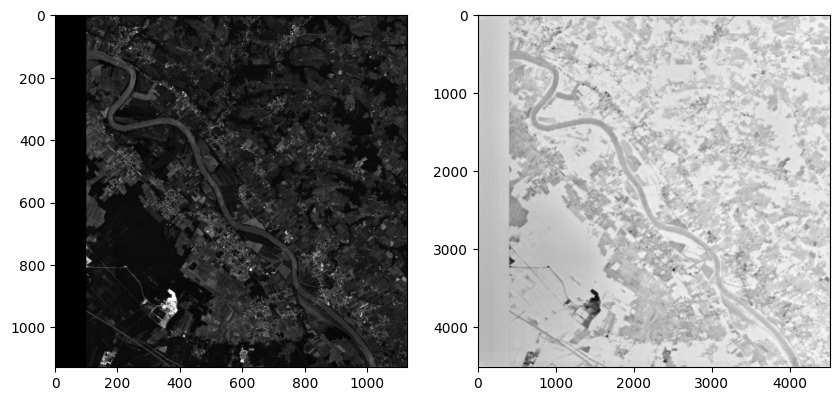

In [12]:
from stelar_spatiotemporal.eopatch_functions import plot_rgb

# Check prediction
patchlet_path = os.path.join(plet_dir, "patchlet_0_4")
eop = EOPatch.load(patchlet_path, lazy_loading=True)

fig,axes = plt.subplots(1,2,figsize=(10,10))
plot_rgb(eop, 0, axes[0])
axes[1].imshow(eop.data_timeless['SEGMENTATION'][...,0], vmin = 0, vmax = 1, cmap='gray')

# 4. Vectorization of segmentation maps

This step will vectorize the segmentation maps of the patchlets into polygons. 
The polygons will be stored in a separate folder called `$DATADIR/contours` as a series of .gpkg files, named by the patchlet.

**Assumptions**:
- One has stored the EOPatch objects containing the patchlets that include segmentation maps in a folder `$DATADIR/patchlets/segment_eopatch`.

**Process**:
The function `vectorize_segmentation_maps` will do the following:
1. Temporarily save the segmentation maps as tiff files to enable vectorization.
2. Vectorize the segmentation maps of the patchlets into polygons using GDAL.
3. Save the polygons in a separate folder called `$DATADIR/contours` as a series of .gpkg files, named by the patchlet.
4. Combine the polygons of the patchlets into a single .gpkg file called `$DATADIR/fields.gpkg`.

In [6]:
from stelar_spatiotemporal.segmentation.segmentation import vectorize_patchlets

plet_dir = os.path.join(TMPDIR, "patchlets")
vecs_dir = os.path.join(TMPDIR, "contours")

# Vectorize patchlets
print("Vectorizing segmentated patchlets")
vectorize_patchlets(plet_dir, outdir=vecs_dir)

Vectorizing segmentated patchlets
Skipping patchlet_0_4 as it is already vectorizedSkipping patchlet_4_3 as it is already vectorizedSkipping patchlet_1_9 as it is already vectorizedSkipping patchlet_7_0 as it is already vectorized

  0%|          | 0/121 [00:00<?, ?it/s]

Skipping patchlet_10_9 as it is already vectorizedSkipping patchlet_6_2 as it is already vectorizedSkipping patchlet_1_4 as it is already vectorizedSkipping patchlet_0_2 as it is already vectorized






Skipping patchlet_0_5 as it is already vectorized
Skipping patchlet_4_7 as it is already vectorizedSkipping patchlet_7_9 as it is already vectorizedSkipping patchlet_10_4 as it is already vectorizedSkipping patchlet_1_10 as it is already vectorized
Skipping patchlet_3_6 as it is already vectorized
Skipping patchlet_5_0 as it is already vectorized
Skipping patchlet_2_5 as it is already vectorizedSkipping patchlet_5_10 as it is already vectorized

Skipping patchlet_0_8 as it is already vectorized



Skipping patchlet_4_6 as it is already vectorizedSkipping patchlet_2_4 as it is already vectorizedSkipping patchlet_3_0 as it is already vectorized

Skipping patchlet_3_4 as it is already vectorized
Skipping patchlet_1_1 as it is already vectorized
Skipping patchlet_7_10 as it is already vect

100%|██████████| 121/121 [00:02<00:00, 48.05it/s]


In [7]:
from stelar_spatiotemporal.segmentation.segmentation import combine_patchlet_shapes

# Combine patchlet shapes
print("Combining patchlet shapes")

vecs_dir = os.path.join(TMPDIR, "contours")
glob.glob(os.path.join(vecs_dir, "*.gpkg"))

outpath = "s3://stelar-spatiotemporal/cool_shapes.gpkg"

combine_patchlet_shapes(vecs_dir, outpath=outpath)

Combining patchlet shapes
